<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Optimized,-w/o-integration-function-though" data-toc-modified-id="Optimized,-w/o-integration-function-though-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Optimized, w/o integration function though</a></span></li><li><span><a href="#With-integration-function-optimized" data-toc-modified-id="With-integration-function-optimized-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>With integration function optimized</a></span></li><li><span><a href="#Using-chunks" data-toc-modified-id="Using-chunks-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Using chunks</a></span><ul class="toc-item"><li><span><a href="#dask-=-'allowed'" data-toc-modified-id="dask-=-'allowed'-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>dask = 'allowed'</a></span></li><li><span><a href="#dask-=-'parallelized'" data-toc-modified-id="dask-=-'parallelized'-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>dask = 'parallelized'</a></span></li></ul></li></ul></div>

In [1]:
import xarray as xr
import vor, vor_fast, vor_fast_setup
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata  

%matplotlib inline

In [2]:
ds_h_sel = xr.open_dataarray('./geos5/geos5_20181209-00_h@10hPa_all.nc')
ds_h_sel_daily = ds_h_sel.resample(time = '1D').mean('time')
ds_h_sel_daily = ds_h_sel_daily.reset_coords(drop=True)
ds_h_sel_daily = ds_h_sel_daily.sel(lat = slice(20,None))
ds_h_sel_daily

<xarray.DataArray 'h' (time: 11, lat: 281, lon: 1152)>
array([[[30739.691, 30739.191, ..., 30740.191, 30740.066],
        [30735.691, 30735.316, ..., 30736.441, 30736.316],
        ...,
        [28757.066, 28757.066, ..., 28757.066, 28757.066],
        [28742.066, 28742.066, ..., 28742.066, 28742.066]],

       [[30732.441, 30732.066, ..., 30733.441, 30732.691],
        [30729.191, 30728.691, ..., 30730.066, 30729.566],
        ...,
        [28710.816, 28710.816, ..., 28710.816, 28710.816],
        [28699.066, 28699.066, ..., 28699.066, 28699.066]],

       ...,

       [[30661.65 , 30662.275, ..., 30660.15 , 30661.15 ],
        [30659.025, 30659.775, ..., 30657.525, 30658.275],
        ...,
        [29084.65 , 29085.025, ..., 29084.525, 29084.525],
        [29062.65 , 29062.65 , ..., 29062.65 , 29062.65 ]],

       [[30654.611, 30655.611, ..., 30654.611, 30654.611],
        [30652.611, 30654.611, ..., 30652.611, 30652.611],
        ...,
        [29058.611, 29058.611, ..., 29057.611, 2

In [16]:
A = 6374.0e3       # Earth radius
DEGRAD = np.pi/180. # conversion of degrees to radians
RADDEG = 180./np.pi # conversion of radians to degrees 

#optimized
def sph_to_car(field, lons, lats, xypoints,resolution):
    nlons = len(lons)
    nlats = len(lats)
    xyvals = []
    for ilon in range(nlons): # -1s needed?
        for ilat in range(nlats):
            xyvals.append(field[ilat,ilon])

    if resolution == 'full':       
        cart_x_points = -1.+np.arange(nlons)/(0.5*nlons)             
        cart_y_points = -1.+np.arange(nlons)/(0.5*nlons)
    elif resolution == 'low':
        cart_x_points = -1.+np.arange(50)/(0.5*50)
        cart_y_points = -1.+np.arange(50)/(0.5*50)
    else:
        raise ValueError()
    
    cart_gridx, cart_gridy = np.meshgrid(cart_x_points,cart_y_points)

    field_cart = griddata(xypoints, np.array(xyvals), (cart_gridx,cart_gridy), \
                        method='linear')  # Might want to change to cubic etc?
                              
    return field_cart, cart_x_points, cart_y_points  
#the same
def isolate_vortex(field_cart, edge, field_type='GPH'):
    """
    Replace vortex into region (outside) equal to field on vortex edge, and 
    region (inside) with values of vortex. 
    For GPH vortex is less than surrounding, for PV it is greater. 
    """
    if field_type == 'GPH':
        field_cart[np.where(field_cart > edge)] = edge
        field_cart[np.isnan(field_cart)] = edge # set NaN regions to edge 
    elif field_type == 'PV':
        field_cart[np.where(field_cart < edge)] = edge
        field_cart[np.isnan(field_cart)] = edge # set NaN regions to edge
    else:
        raise ValueError() # maybe want more specific error type

    return field_cart
#the same
def moment_integrate(vtx_field, x, y,edge):
    """
    Performs moment diagnostic calculations on cartesian field
    """

    # x and y are cartesian gridpoints; vtx_field is cartesian field
    # edge is value on vortex edge 

    box_length = 2*A/len(x)
    box_area = box_length**2

    # Set up moment diagnostics
    M00 = 0
    M10 = 0
    M01 = 0
    Marea = 0
    # Integrate over vortex
    for ix in range(len(x)):
        for iy in range(len(y)):
            
            M00 += abs(vtx_field[ix,iy]-edge)*(x[ix]**0)*(y[iy]**0) 
            M10 += abs(vtx_field[ix,iy]-edge)*(x[ix]**1)*(y[iy]**0) 
            M01 += abs(vtx_field[ix,iy]-edge)*(x[ix]**0)*(y[iy]**1)
            Marea += abs(vtx_field[ix,iy]-edge)*(x[ix]**0)*(y[iy]**0)*box_area
            
    # Calculate centroid 
    centx = M10/M00
    centy = M01/M00

    # Convert back to polar coordinates 
    R = centx**2 + centy**2
    #loncent = np.arctan(centx/centy)*RADDEG
    latcent = np.arcsin((1-R)/(1+R))*RADDEG

    # Set up relative moment diagnostics 
    J11=0
    J20=0
    J02=0
    #J22=0
    #J40=0
    #J04=0
    for ix in range(len(x)):
        for iy in range(len(y)):
            
            J11 += abs(vtx_field[ix,iy]-edge)*((x[ix]-centx)**1)*((y[iy]-centy)**1)
            J20 += abs(vtx_field[ix,iy]-edge)*((x[ix]-centx)**2)*((y[iy]-centy)**0)
            J02 += abs(vtx_field[ix,iy]-edge)*((x[ix]-centx)**0)*((y[iy]-centy)**2)
            #J22 += abs(vtx_field[ix,iy]-edge)*((x[ix]-centx)**2)*((y[iy]-centy)**2)
            #J40 += abs(vtx_field[ix,iy]-edge)*((x[ix]-centx)**4)*((y[iy]-centy)**0)
            #J04 += abs(vtx_field[ix,iy]-edge)*((x[ix]-centx)**0)*((y[iy]-centy)**4)   

    # Calculate angle between x-axis and major axis of ellipse                  
    #angle = 0.5*np.arctan((2*J11)/(J20-J02))*RADDEG

    # Calculate aspect ratio
    aspect_ratio = np.sqrt(abs(( (J20+J02) + np.sqrt(4*(J11**2)+(J20-J02)**2) ) / \
                               ( (J20+J02) - np.sqrt(4*(J11**2)+(J20-J02)**2) ))) 
    ar = aspect_ratio #short name for later calculation

    # Calculate objective area
    #objective_area = Marea/edge 


    # Calculate excess kurtosis 
    #kurtosis = M00 * (J40+2*J22+J04)/((J20+J02)**2) \
    #                     - (2./3.)*( (3*(ar**4)+2*(ar**2)+3) / (((ar**2)+1)**2) ) 
                   
    return aspect_ratio, latcent 

def moment_integrate2(vtx_field, x, y,edge):
    """
    Performs moment diagnostic calculations on cartesian field
    """

    # x and y are cartesian gridpoints; vtx_field is cartesian field
    # edge is value on vortex edge 

    box_length = 2*A/len(x)
    box_area = box_length**2

    # Set up moment diagnostics
    M00 = 0
    M10 = 0
    M01 = 0
    Marea = 0
    # Integrate over vortex
          
    M00 = np.sum(np.abs(vtx_field-edge)*(x[:,np.newaxis]**0)*(y[np.newaxis,:]**0))
    M10 = np.sum(np.abs(vtx_field-edge)*(x[:,np.newaxis]**1)*(y[np.newaxis,:]**0))
    M01 = np.sum(np.abs(vtx_field-edge)*(x[:,np.newaxis]**0)*(y[np.newaxis,:]**1))
    Marea = np.sum(np.abs(vtx_field-edge)*(x[:,np.newaxis]**0)*(y[np.newaxis,:]**0)*box_area)
            
    # Calculate centroid 
    centx = M10/M00
    centy = M01/M00

    # Convert back to polar coordinates 
    R = centx**2 + centy**2
    latcent = np.arcsin((1-R)/(1+R))*RADDEG
    
    # Set up relative moment diagnostics 
    J11=0
    J20=0
    J02=0
    J11 = np.sum(np.abs(vtx_field-edge)*((x[:,np.newaxis]-centx)**1)*((y[np.newaxis,:]-centy)**1))
    J20 = np.sum(np.abs(vtx_field-edge)*((x[:,np.newaxis]-centx)**2)*((y[np.newaxis,:]-centy)**0))
    J02 = np.sum(np.abs(vtx_field-edge)*((x[:,np.newaxis]-centx)**0)*((y[np.newaxis,:]-centy)**2))
    aspect_ratio = np.sqrt(abs(( (J20+J02) + np.sqrt(4*(J11**2)+(J20-J02)**2) ) / \
                               ( (J20+J02) - np.sqrt(4*(J11**2)+(J20-J02)**2) ))) 
    return aspect_ratio, latcent

def calc_moments(field, lats, lons, xypoints, hemisphere='NH', field_type='GPH', \
                 edge=3.02e4, resolution='full'):
    field_cart, x, y = sph_to_car(field,lons,lats,xypoints,resolution)
    field_vtx = isolate_vortex(field_cart, edge, field_type)
   
    aspect_ratio, latcent = moment_integrate2(field_vtx, x, y,edge)
        
    return {'aspect_ratio':aspect_ratio, 'centroid_latitude':latcent}
                 
def calc_xypoints(lons, lats):
    DEGRAD = np.pi/180.
    lons = lons * DEGRAD
    lats = lats * DEGRAD
    x = (np.cos(lons[:,np.newaxis])*np.cos(lats))/ (1. + np.sin(lats[np.newaxis,:]))               
    y = (np.sin(lons[:,np.newaxis])*np.cos(lats[np.newaxis,:]))/(1. + np.sin(lats[np.newaxis,:]))
    nlon_nlat = lons.shape[0]*lats.shape[0]
    xypoints = np.stack([x.reshape(nlon_nlat),y.reshape(nlon_nlat)], axis = 1)
    return xypoints
                 
def moments_fce(arr):
    moments = calc_moments(arr,lats,lons,xypoints,'NH','GPH',3.02e4)
    return np.array([moments['aspect_ratio'], moments['centroid_latitude']])

In [7]:
lons = ds_h_sel_daily.lon.values
lats = ds_h_sel_daily.lat.values
xypoints = calc_xypoints(lons,lats)

In [8]:
ds_h_sel_daily[:]

<xarray.DataArray 'h' (time: 11, lat: 281, lon: 1152)>
array([[[30739.691, 30739.191, ..., 30740.191, 30740.066],
        [30735.691, 30735.316, ..., 30736.441, 30736.316],
        ...,
        [28757.066, 28757.066, ..., 28757.066, 28757.066],
        [28742.066, 28742.066, ..., 28742.066, 28742.066]],

       [[30732.441, 30732.066, ..., 30733.441, 30732.691],
        [30729.191, 30728.691, ..., 30730.066, 30729.566],
        ...,
        [28710.816, 28710.816, ..., 28710.816, 28710.816],
        [28699.066, 28699.066, ..., 28699.066, 28699.066]],

       ...,

       [[30661.65 , 30662.275, ..., 30660.15 , 30661.15 ],
        [30659.025, 30659.775, ..., 30657.525, 30658.275],
        ...,
        [29084.65 , 29085.025, ..., 29084.525, 29084.525],
        [29062.65 , 29062.65 , ..., 29062.65 , 29062.65 ]],

       [[30654.611, 30655.611, ..., 30654.611, 30654.611],
        [30652.611, 30654.611, ..., 30652.611, 30652.611],
        ...,
        [29058.611, 29058.611, ..., 29057.611, 2

# Optimized, w/o integration function though

In [11]:
moments_xr = xr.apply_ufunc(moments_fce, ds_h_sel_daily[:], \
                            input_core_dims=[['lat', 'lon']], \
                            output_core_dims=[['vars']], vectorize=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater


In [12]:
moments_xr

<xarray.DataArray 'h' (time: 11, vars: 2)>
array([[ 1.786421, 79.144072],
       [ 2.007545, 81.204711],
       [ 2.157441, 81.365926],
       [ 2.174224, 80.909784],
       [ 2.117976, 80.349988],
       [ 2.049652, 78.916104],
       [ 1.94017 , 76.899323],
       [ 1.866561, 74.901959],
       [ 1.769069, 73.318562],
       [ 1.637021, 72.23285 ],
       [ 1.567425, 71.856548]])
Coordinates:
  * time     (time) datetime64[ns] 2018-12-09 2018-12-10 ... 2018-12-19
Dimensions without coordinates: vars

In [13]:
moments_xr['vars'] = ['aspect_ratio', 'centroid_latitude']#.reset_coords()
moments_ds = moments_xr.to_dataset(dim = 'vars') #.reset_coords('vars')

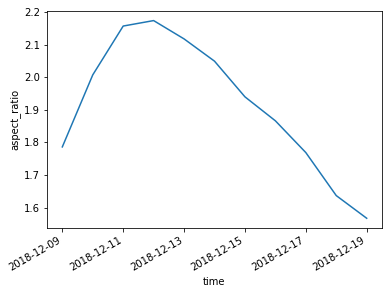

In [14]:
moments_ds['aspect_ratio'].plot()

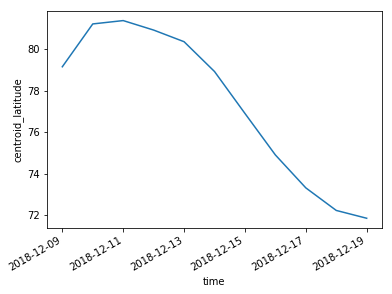

In [15]:
moments_ds['centroid_latitude'].plot()

# With integration function optimized

In [17]:
moments_xr2 = xr.apply_ufunc(moments_fce, ds_h_sel_daily[:], \
                            input_core_dims=[['lat', 'lon']], \
                            output_core_dims=[['vars']], vectorize=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater


In [18]:
moments_xr2['vars'] = ['aspect_ratio', 'centroid_latitude']#.reset_coords()
moments_ds2 = moments_xr2.to_dataset(dim = 'vars') #.reset_coords('vars')

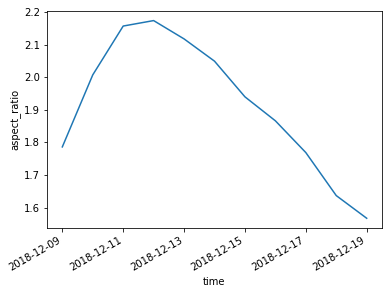

In [19]:
moments_ds2['aspect_ratio'].plot()

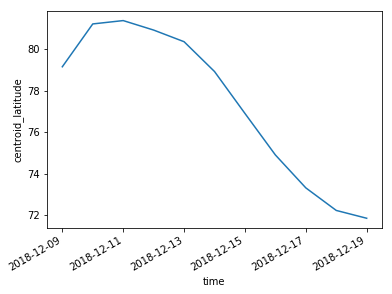

In [20]:
moments_ds2['centroid_latitude'].plot()

# Using chunks

## dask = 'allowed'

In [24]:
moments_xr3 = xr.apply_ufunc(moments_fce, ds_h_sel_daily.chunk({'time': 1}), \
                            input_core_dims=[['lat', 'lon']], \
                            output_core_dims=[['vars']], \
                            output_dtypes = [float], vectorize=True, \
                            dask = 'allowed')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater


## dask = 'parallelized'

In [27]:
moments_xr4 = xr.apply_ufunc(moments_fce, ds_h_sel_daily.chunk({'time': 1}), \
                            input_core_dims=[['lat', 'lon']], \
                            output_core_dims=[['vars']], \
                            output_dtypes = [float], vectorize=True, \
                            dask = 'parallelized',\
                            output_sizes = dict(vars = 2)).compute()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater


In [28]:
moments_xr4['vars'] = ['aspect_ratio', 'centroid_latitude']#.reset_coords()
moments_ds4 = moments_xr4.to_dataset(dim = 'vars') #.reset_coords('vars')

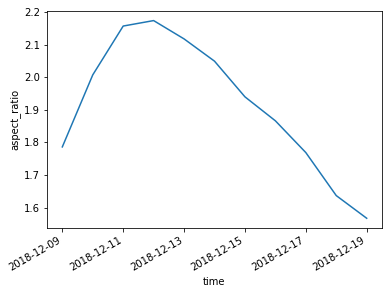

In [29]:
moments_ds4['aspect_ratio'].plot()

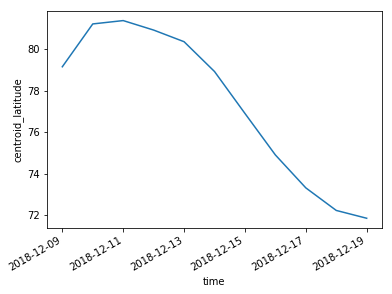

In [30]:
moments_ds4['centroid_latitude'].plot()